### In this notebook, we explore methods of reverse engineering coherenece matrix given the simulation result of random walk of agent/agents in the coherennce matrix.

In [5]:
import pandas as pd
import numpy as np
import random
from random import shuffle, randrange
from collections import defaultdict
from .scripts import utilities
import utilities

import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named '__main__.scripts'; '__main__' is not a package

In [2]:
%matplotlib inline

Below is the coherence matrix generation function

In [3]:
def coherence_function(k):
    """This function for generating coherence matrix """
    m = np.zeros((2**k, k))             # initialize matrix to all zeros same as Let m = matrix(len(states),numbits,0)
    numbits = [i for i in range(10)]    # this is just the temporary variable for shuffling the bits order
    for s, row in enumerate(m) :        # for s in states:  # walk through each row in the matrix
        p = random.uniform(.5,.9)       # select an initial random val
        bits = numbits[:]               # this is only for using the orderly list of 10 bits and next line shuffles every iteration
        shuffle(bits)                   # this just randomly goes through the bits
        for b in bits:
            if p < 0.01: 
                break                   # if p is close enough to zero, just stop
            m[s,b] = p                  # otherwise assign probability to the bit of that state where s is row/state and bit is column number of matrix
            p = p/2                     # for next iteration divide the probability by 2
    return m

In [4]:
# creating coherence matrix
coh_matrix = coherence_function(10)

After creating coherence matrix, next we place an agent to random state i.e. some row of the coherence matrix, we also give random knowledge state for the state.

In [5]:
knowledge_state_index = randrange(1024) # select a random row/state from the matrix
knowledge_state = np.random.randint(2, size=10).tolist() # we assign random value to start with

knowledge_transition = defaultdict(list) # this is to keep track of list of values

Then at each step, the probability of changing a bit is computed and next state is defined based on the result values.

In [6]:

# for 10000 time steps we will run the through the knowledge states
for k in range(1000000):
    next_state = [] # we will insert each bit of next state to list to keep track of bits flipped and it becomes current bits of state for next state
    knowledge_state_probabilities = coh_matrix[knowledge_state_index] # select the row/state we are in (which initially was randomly selected)
    
    # once we have selected the row from the matrix we look into flipping each bit knowledge space
    for i, flip_bit_probability in enumerate(knowledge_state_probabilities):
        rand_val = np.random.rand() # this is rolling a random number which we check for whether or not to flip the bit
        
        if flip_bit_probability>rand_val: # if the flipping bit probability is higher than random value we flip from 1 to 0 or 0 to 1
            next_state.append(1^knowledge_state[i]) # using XOR for 1 to 0 or 0 to 1
            
        else: # else we keep the state bit unchanged
            next_state.append(knowledge_state[i])

    # next we insert all these iteration values to defaultdict for further explorations
    knowledge_transition['Current State'].append(utilities.bool2int(knowledge_state)) # keeping track of decimal value of current state
    knowledge_transition['Current_Knowledge_State'].append(knowledge_state) # keeping raw bits of knowledge which we look for comparing number of bits flipped in each states 
    knowledge_transition['Next State'].append(utilities.bool2int(next_state)) # keeping track of decimal value of next state
    knowledge_transition['Next_Knowledge_State'].append(next_state) # keeping raw bits of knowledge which we compare with current state to look into how many bits were flipped every time
    knowledge_state_index = utilities.bool2int(next_state) # selecting next state for the walk
    
    # for next iteration knowledge state would change to next_state determined after looking into probablities
    knowledge_state = next_state
    
# creating pandas dataframe so it may be easier for other analysis
df = pd.DataFrame(knowledge_transition).reset_index()
df.rename(columns={'index':'Time'}, inplace=True)

df_states_count = df[['Time', 'Current State', 'Next State']].groupby(['Current State', 'Next State']).size().to_frame('Count')
df_states_count.sort_values('Count', ascending=False, inplace=True)

df = df_states_count.copy().reset_index()

Viewing current and next state and the counts for the transitions.

In [7]:
df.head()

,Current State,Next State,Count
0,702,686,1049
1,894,890,1038
2,605,597,978
3,292,420,928
4,605,605,902


Once we have list of current states and next states, we look into building coherence matrix with states transitions results.

In [8]:
kbits_dict = defaultdict(list)

for i in range(1024):
    kbits_dict['State'].append(i)
    kbits_dict['binary'].append('{0:010b}'.format(i))
    
    kbits_dict['binary_list'].append(list('{0:010b}'.format(i)))

kbits_mapper_df = pd.DataFrame(kbits_dict)
kbits_mapper_df.set_index('State', inplace=True)
kbits_mapper_df.drop('binary', inplace=True, axis=1)

In [9]:
kbits_mapper_df.head()

,binary_list
State,
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
3,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]"
4,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"


This bits and states are used as dicitionary for using which bits changes when states changes. There may be easier way.

In [10]:
kbits_mapper_df_dict = kbits_mapper_df.to_dict(orient='index')

First create empty matrix with all zeros for the probability for coherence matrix esitmation:

In [11]:
c = np.zeros((1024, 10))

Next iterate through each state transisitons and look into which bits are changed and we estimate the probability by change in bits to the number of times transitions occured.

In [12]:
for state in range(1024):
    state_bitschange_tracker = defaultdict(list)
    
    out_states_df =  df[df['Current State']==state]
    in_binary = kbits_mapper_df_dict[state]['binary_list'][::-1]
    for index, row in out_states_df.iterrows():
        out_binary = kbits_mapper_df_dict[row['Next State']]['binary_list'][::-1]
        for b in range(10):
            if in_binary[b] != out_binary[b]:
                state_bitschange_tracker[b].append(row['Count'])
  
    total = df[df['Current State'] == state]['Count'].sum()
    
    for k, v in state_bitschange_tracker.items():
        c[state, k] = (sum(v)/total) 


Viewing top 5 for simple comparision on how it looks for tru coherence matrix and estimated coherence matrix.

In [13]:
print('True Coherence Matrix')
pd.DataFrame(coh_matrix).head()

True Coherence Matrix


,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.070648,0.000000,0.000000,0.141296,0.565186,0.282593,0.017662,0.035324,0.000000
1,0.000000,0.000000,0.000000,0.046654,0.186616,0.373233,0.023327,0.011664,0.093308,0.746465
2,0.215594,0.862375,0.053898,0.000000,0.107797,0.026949,0.000000,0.000000,0.431188,0.013475
3,0.000000,0.019194,0.076776,0.000000,0.614209,0.153552,0.038388,0.000000,0.000000,0.307105
4,0.096809,0.000000,0.000000,0.387236,0.774471,0.024202,0.193618,0.012101,0.048404,0.000000


In [14]:
print('Esitmated Coherence Matrix')
pd.DataFrame(c).head()

Esitmated Coherence Matrix


,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.077331,0.000000,0.000000,0.130297,0.557733,0.276483,0.013771,0.035487,0.000000
1,0.000000,0.000000,0.000000,0.039301,0.180980,0.357108,0.020378,0.009219,0.098496,0.731198
2,0.253846,0.838462,0.067308,0.000000,0.121154,0.032692,0.000000,0.000000,0.442308,0.009615
3,0.000000,0.019462,0.082484,0.000000,0.627433,0.179796,0.048193,0.000000,0.000000,0.324374
4,0.096916,0.000000,0.000000,0.384728,0.760646,0.024963,0.182085,0.010279,0.046990,0.000000


Viewing the difference in real and coherence matrix with box plot and statistical descriptions. We looked into worst case by looking into maximum possible difference for each row that is state transitions probablities.

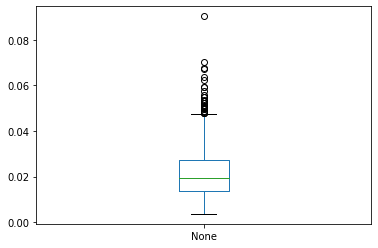

In [15]:
diff_mat = pd.DataFrame(np.abs(coh_matrix - c)).max(axis=1)
diff_mat.plot(kind='box');

In [16]:
pd.DataFrame(diff_mat.describe()).T

,count,mean,std,min,25%,50%,75%,max
0,1024.0,0.021561,0.010908,0.003576,0.013546,0.01926,0.027187,0.090421


We can see the estimates were not off by too much.

In [17]:
pd.DataFrame(np.abs(coh_matrix - c))

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.006682,0.000000,0.000000,0.011000,0.007453,0.006110,0.003891,0.000163,0.000000
1,0.000000,0.000000,0.000000,0.007353,0.005636,0.016124,0.002949,0.002445,0.005188,0.015267
2,0.038252,0.023914,0.013409,0.000000,0.013357,0.005743,0.000000,0.000000,0.011120,0.003859
3,0.000000,0.000268,0.005708,0.000000,0.013223,0.026244,0.009805,0.000000,0.000000,0.017270
4,0.000107,0.000000,0.000000,0.002507,0.013825,0.000761,0.011533,0.001822,0.001415,0.000000
...,...,...,...,...,...,...,...,...,...,...
1019,0.032806,0.000000,0.000000,0.011347,0.006291,0.004045,0.000000,0.002022,0.017414,0.006404
1020,0.000000,0.009160,0.000811,0.000000,0.010300,0.003951,0.000000,0.000216,0.000776,0.000000
1021,0.000000,0.000000,0.003903,0.004180,0.007199,0.002990,0.004693,0.001549,0.000000,0.001312
1022,0.000000,0.010655,0.000300,0.002551,0.000000,0.002288,0.000375,0.002705,0.000000,0.010806
